### The Ising Model 

The Ising Model is a model of magnetism in statistical mechanics, with discrete manetic moments (spins) on a lattice. The model can be solved exactly in one or two (but not three) dimensions. 

Each spin contributes to the total energy via its interactions with other spins and the external field. In the simplest model, there is no external magnetic field, and only nearest neighbour spin interactions are considered when calculating the energy of a particular configuration. Interactions between spins can be either ferromagentic (energetically favourable for spins to align) or antiferromagnetic (energetically favourable for spins to orient antiparallel to their neighbours). 

There are three possible regular lattice geometries in 2D: square, triangular and hexagonal, with a square lattice the easiest to model. A natural representation of the system in Python stores the lattice configuration as a (2D) numpy array, with entries of +1 or -1 corresponding to whether each spin is up or down. Such a finite 2D array can be used to model a number of 2D lattice geometries - not just a square. Both the lattice type (e.g. 'triangular' or 'square') and periodic boundary conditions (enabling the model to simulate a much larger lattice) can be implemented by carefully defining which lattice sites (i.e. which array elements) are neighbours. In particular, triangular / hexagonal lattices are interesting when the interaction is antiferromagnetic: some frustration is always inevitable, whereas on a square lattice a 'chessboard' configuration with no frustration is possible. 

At present the model only allows for a ferromagnetic square lattice.

The model uses Monte Carlo simulation to equilibrate the system - equilibrium properties can then be calculated. The Metropolis algorithm is perhaps the simplest such method: at each monte carlo step, a spin is selected at random and flipped: (a) with probability 1 if the flip is energetically favourable or (b) with some probability dependent on the parameters of the model, corresponding to a thermal fluctuation, if the flip is energetically unfavourable. 

This method slows down close to equilibrium, as fewer spins lie at the boundaries of domains and flips become less likely. The Wolff Cluster method is far more efficient: at each Monte Carlo step, a cluster of aligned spins (in the ferromagnetic case) is found/constructed, then flipped. This enables much faster equilibration. 

N.B.: neither method represents a dynamical process - the Monte Carlo steps do not represent time steps. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt


class Ising2D:
    'Class for 2D Ising Model'

    def __init__(self, linear_size, kT, J):
        '''User initialised, no defaults
        linear_size must be an integer (lattice side length)
        kT, J must be int or floating point (J is the interaction strength).
        Initialisation is easiest if either kT or J is set = 1
        and the other parameter varied, since it is the ratio kT/J
        that determines the beaviour of the system'''
        self.linear_size = linear_size
        self.KT = kT
        self.J = J

    def initialise_lattice(self):
        '''Initialise a lattice of spins,
        each with independent and equal probability of being up or down'''
        lattice0 = np.random.rand(self.linear_size, self.linear_size)
        binary_lattice = lattice0 > 0.5
        self.lattice = 2*binary_lattice - 1

    def single_to_double_index(self, n):
        L = self.linear_size
        i = np.floor(n/L)
        j = np.mod(n, L)
        return int(i), int(j)

    def double_to_single_index(self, i, j):
        L = self.linear_size
        n = (i * L) + j
        return int(n)

    def square_lattice_neighbours(self, i, j, L):
        '''Nearest neighbouring spins: this function defines a square lattice:
                X
              X 0 X
                X
        returns an array with entries corresponding to the four nearest
        neighbours of the given lattice site'''
        nn = np.zeros([4, 2], dtype=np.int)

        # order: top, left, right, bottom
        nn[0, :] = np.mod(i + 1, L), j
        nn[1, :] = i, np.mod(j - 1 + L, L)
        nn[2, :] = i, np.mod(j + 1, L)
        nn[3, :] = np.mod(i - 1 + L, L), j
        return nn

    def generate_neighbour_list(self):
        L = self.linear_size
        neighbours = np.zeros([L, L, 4, 2], dtype=np.int)
        for s in range(L * L):
            i, j = self.single_to_double_index(s)
            nn = self.square_lattice_neighbours(i, j, L)
            neighbours[i, j, :] = nn
        self.neighbour_list = neighbours

    def random_update_lattice_single_spin(self):
        '''Pick a single lattice site at random and flip
        if energetically favourable (or due to thermal fluctuation)
        Motropolis Monte Carlo algorithm'''
        L = self.linear_size
        site = np.random.randint(L * L)
        i, j = self.single_to_double_index(site)
        spin = self.lattice[i, j]

        E_0 = 0

        for nind in range(4):
            p, q = self.neighbour_list[i, j, nind, :]
            E_0 -= self.lattice[p, q] * spin * J
        delta_E = -2 * (E_0)

        if delta_E < 0:  # flip if energetically favourable
            self.lattice[i, j] = - spin
        else:  # flip probabilistically due to thermal fluctuation
            if np.random.random() < np.exp(-delta_E / kT):
                self.lattice[i, j] = - spin

    def flip_wolff_cluster(self, i, j):
        '''Given a single lattice site, construct a cluster
        (list of tuples [(a, b)] representing lattice sites of cluster members)
        according to Wolff algorithm'''

        cluster_spin = self.lattice[i, j]
        self.lattice[i, j] = -cluster_spin  # flip initial spin
        additions = [(i, j)]
        finished_checking = False

        while finished_checking == False:
            to_consider = additions  # Only consider potential bonds once
            additions = []  # clear at start of each round
            n_additions = 0

            # loop over cluster members not yet checked
            for cluster_member in to_consider:
                a, b = cluster_member
                # loop over neighbours
                for nind in range(4):
                    p, q = self.neighbour_list[a, b, nind, :]
                    # Decide whether neighbouring spin joins cluster
                    if ((self.lattice[p, q] == cluster_spin) &
                            (np.random.random() < (1 - np.exp(- (2*J) / kT)))):
                        # flip immediately to avoid considering again
                        self.lattice[p, q] = - self.lattice[p, q]
                        additions.append((p, q))
                        n_additions += 1

            if n_additions == 0:
                finished_checking = True

    def wolff_cluster_update(self):
        '''Pick a lattice site at random, construct a Wolff cluster around it,
        then flip all spins in cluster'''
        i = np.random.randint(self.linear_size)
        j = np.random.randint(self.linear_size)
        self.flip_wolff_cluster(i, j)

    def display_lattice(self, title):
        '''Plot lattice as monochrome heatmap using matplotlib.pyplot'''
        plt.imshow(self.lattice, cmap='hot', interpolation='nearest')
        plt.title(title)
        plt.show()


In [22]:
# Parameters

J = 1                 # Scale factor for spin energy
linear_size = 60      # lattice side length (periodic boundary conditions)
N = linear_size ** 2  # number of lattice sites
mc_steps = 400        # total number of Monte Carlo steps
                      # 200 is good for a 60x60 lattice using Wolff
                      # a 60x60 lattice with Metropolis will need 10^5-6

# MAIN PROGRAM

kT_values = 31
kT_list = np.linspace(1.5, 3.0, kT_values)
m = []

np.random.seed()

for kT in kT_list:
    print('kT =', kT)  # display progress
    model = Ising2D(linear_size, kT, J)
    model.initialise_lattice()
    model.generate_neighbour_list()
    # model.display_lattice('Initial lattice configuration')

    for t in range(mc_steps):  # WOLFF
        model.wolff_cluster_update()
        # model.display_lattice('Model after ' + str(t) + ' Wolff flips')
        m_sim = []
        if t > mc_steps/2:
            # Keep track of average magnetisation per spin
            m_sim.append(np.sum(model.lattice) / float(N))
            m_sim = np.absolute(m_sim)
    m.append(np.mean(m_sim))


kT = 1.5
kT = 1.55
kT = 1.6
kT = 1.65
kT = 1.7
kT = 1.75
kT = 1.8
kT = 1.85
kT = 1.9
kT = 1.95
kT = 2.0
kT = 2.05
kT = 2.1
kT = 2.15
kT = 2.2
kT = 2.25
kT = 2.3
kT = 2.35
kT = 2.4
kT = 2.45
kT = 2.5
kT = 2.55
kT = 2.6
kT = 2.65
kT = 2.7
kT = 2.75
kT = 2.8
kT = 2.85
kT = 2.9
kT = 2.95
kT = 3.0


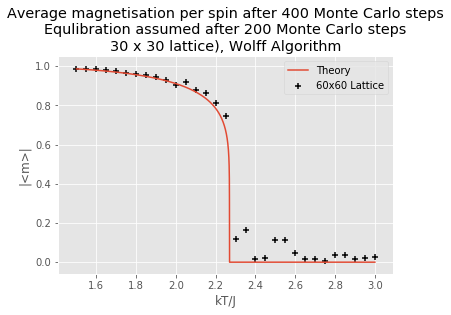

In [28]:
# Compare theory with simulation

def predict_m(BJ):
    num = (1 - (np.tanh(BJ)**2))**4
    denom = 16 * (np.tanh(BJ)**4)
    result = (1 - (num / denom))
    if result < 0:
        result = 0
    result = result**(1/8)
    return result

kT_linspace = np.linspace(kT_list.min(), kT_list.max(), 10000)
BJ_list = (J * np.ones(len(kT_linspace))) / kT_linspace

predictions = np.zeros(len(BJ_list))
for i in range(len(BJ_list)):
    predictions[i] = predict_m(BJ_list[i])

plt.style.use('ggplot')
plt.figure(figsize=(6, 4))
plt.plot(kT_linspace, predictions, label='Theory')
plt.scatter(kT_list, m, marker='+', c='black', label='60x60 Lattice')
plt.xlabel('kT/J')
plt.ylabel('|<m>|')
plt.legend(loc='upper right')

plt.title('Average magnetisation per spin after ' + str(mc_steps)
          + ' Monte Carlo steps\nEqulibration assumed after ' + str(int(mc_steps/2))
          + ' Monte Carlo steps\n' + str(linear_size) + ' x '
          + str(linear_size) + ' lattice), Wolff Algorithm')
plt.show()


A phase transition is seen at kT/J ~ 2.3 as expected.

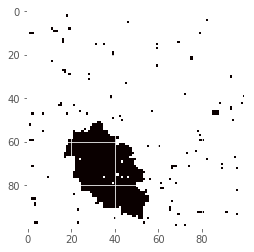

In [31]:
J = 1
kT = 1.6
linear_size = 100
model = Ising2D(linear_size, kT, J)
model.initialise_lattice()
model.generate_neighbour_list()
    
# model.display_lattice('Initial lattice configuration')

for t in range(5000000):
    # METROPOLIS
    model.random_update_lattice_single_spin()
plt.imshow(model.lattice, cmap='hot', interpolation='nearest')
filename = str(t) + '.jpg'
plt.show()
